In [188]:
from os.path import exists
import re
from glob import glob
import numpy as np
import pandas as pd
from google.colab import drive
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
import matplotlib
from wordcloud import WordCloud

In [189]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [190]:
# dados extraídos de: https://dadosabertos.camara.leg.br/swagger/api.html#staticfile
data_path = {
    'proposicoes': '/content/drive/MyDrive/TrabalhoFinalCOS738/dataProposicoes/proposicoes/*.xlsx',
    'autores': '/content/drive/MyDrive/TrabalhoFinalCOS738/dataProposicoes/proposicoesAutores/*.xlsx',
    'temas': '/content/drive/MyDrive/TrabalhoFinalCOS738/dataProposicoes/proposicoesTemas/*.xlsx',
}
# pre-processed output filename
output = '/content/drive/MyDrive/bmt_projeto_final_preprocessed.gzip'

In [191]:
if not exists(output):
  # read xlsx files
  data = {}
  for k, p in data_path.items():
    print(f'reading {k} in {p}...')
    data[k] = pd.concat([pd.read_excel(f) for f in glob(p)])
  # filtering
  # Apenas projetos de lei
  data['proposicoes'] = data['proposicoes'].loc[data['proposicoes']['siglaTipo'] == 'PL']
  # merging
  dataset = data['proposicoes'].merge(data['autores'], suffixes=('_proposicao', '_autor'), left_on='id', right_on='idProposicao', how='left')
  dataset = dataset.merge(data['temas'], left_on='uri', suffixes=('_proposicao', '_tema'), right_on='uriProposicao', how='left')
  dataset = dataset[['id', 'ano_proposicao', 'ementa', 'ementaDetalhada', 'keywords', 'tema', 'nomeAutor', 'siglaPartidoAutor', 'siglaUFAutor', 'ordemAssinatura']]
  dataset = dataset.rename(columns={'ano_proposicao': 'ano'})
  dataset.to_json(output, compression='gzip')
else:
  # read existing file
  dataset = pd.read_json(output, compression='gzip')


In [192]:
dataset

id   ano                                             ementa  \
0        303153  2022  Dispõe sobre o exercício da profissão de Podól...   
1        587207  2022  Dispõe sobre a prestação dos serviços de contr...   
2        587207  2022  Dispõe sobre a prestação dos serviços de contr...   
3       2313792  2022  Determina às empresas de transporte de passage...   
4       2313792  2022  Determina às empresas de transporte de passage...   
...         ...   ...                                                ...   
186157   543876  1946  ASSEGURA O INGRESSO NA CLASSE INICIAL DA CARRE...   
186158   607205  1946  DISPÕE SOBRE A EXPEDIÇÃO DE DIPLOMAS DE BACHAR...   
186159   556557  1945  DÁ NOVA REDAÇÃO AOS ARTIGOS 817 E 830 DO CÓDIG...   
186160   347964  1935                                               None   
186161   517496  1934         MODIFICA DISPOSITIVOS DO CÓDIGO ELEITORAL.   

                                          ementaDetalhada  \
0       Regulamentando o exercício profissional da Pod...   
1                                                    None   
2                                                    None   
3                                                    None   
4                                                    None   
...                                                   ...   
186157                                               None   
186158                                               None   
186159                                               None   
186160                                               None   
186161                                               None   

                                                 keywords  \
0       Regulamentação, profissão, Podólogo, competênc...   
1       Regulamentação, atividade, empresa especializa...   
2       Regulamentação, atividade, empresa especializa...   
3       Obrigatoriedade, Empresa de transporte, transp...   
4       Obrigatoriedade, Empresa de transporte, transp...   
...                                                   ...   
186157                                               None   
186158                                               None   
186159                                               None   
186160                                               None   
186161                                               None   

                                               tema  \
0                                Trabalho e Emprego   
1                    Indústria, Comércio e Serviços   
2                                             Saúde   
3                       Direitos Humanos e Minorias   
4       Meio Ambiente e Desenvolvimento Sustentável   
...                                             ...   
186157                                         None   
186158                                         None   
186159                                         None   
186160                                         None   
186161                                         None   

                                               nomeAutor siglaPartidoAutor  \
0                                            José Mentor                PT   
1                                       Laercio Oliveira                PR   
2                                       Laercio Oliveira                PR   
3                                            Odair Cunha                PT   
4                                            Odair Cunha                PT   
...                                                  ...               ...   
186157                                JOSE FONTES ROMERO              None   
186158                                     MEDEIROS NETO              None   
186159                                   Poder Executivo              None   
186160                    Comissão do Código Eleitoral 2              None   
186161  COMISSÃO ESPECIAL DE REFORMA DO CÓDIGO ELEITORAL              None   

       siglaUFAutor  ordemAssinatura

# Filtros

In [193]:
# @title Filtros
ano_start = 1934 # @param {type:"slider", min:1934, max:2022, step:1}
ano_end = 2022 # @param {type:"slider", min:1934, max:2022, step:1}
partido = "PT" # @param ["", "PT", "PR", "PDT", "PSDB", "PSOL", "PCdoB", "PSB", "PSD", "PV", "SOLIDARI", "PODE", "AVANTE", "PP", "REPUBLIC", "PTB", "PSL", "MDB", "CIDADANIA", "PL", "DEM", "PATRIOTA", "PSC", "UNIÃO", "NOVO", "PROS", "REDE", "S.PART.", "PODEMOS", "PMDB", "PRB", "SD", "REPUB", "Podemos", "PPS", "PHS", "PEN", "PATRI", "S/Partido", "PTC", "PTN", "SOLIDARIED", "PMN", "SemPartido", "PRP", "PTdoB", "PMB", "S Partido", "SDD", "PSDC", "PRTB", "Rede", "PMBD", "PC do B", "PC DOB", "S/Part", "PT -", "PC DO  B", "pRB", "psdb", "pp", "pdt", "prb", "pmdb", "pt", "Nn", "nm", "NN", "AA", "PSBD", "dem", "PCDB", "PFL", "DOM", "PSBB", "PAN", "S/PARTIDO", "PRONA", "PMR", "PPB", "SPART", "PST", "PBDB", "PCDOB", "PPR", "PSTU", "PRN", "PDS", "PDC", "PTR", "PCB", "PRS", "PLP", "PTDOB", "PJ", "PDB", "PS", "PDMB", "PMDF", "MDB*", "ARENA", "PP**", "PNI", "Arena", "UDN", "MEB", "MTR", "PSP", "MRT", "PRT"]

In [194]:
dataset = dataset.loc[dataset['ano'] >= ano_start]
dataset = dataset.loc[dataset['ano'] <= ano_end]
if partido:
  dataset = dataset.loc[dataset['siglaPartidoAutor'] == partido]

# Processamento do texto

In [195]:
num_topics = 100 # @param {type: "integer"}
num_words_per_topic = 10 # @param {type: "integer"}

In [196]:
# transform data to get only text inputs
def join_text(line):
  ementa, ementaDetalhada, keywords = line['ementa'], line['ementaDetalhada'], line['keywords']
  text = ''
  if not pd.isna(ementa):
    text += ementa
  if not pd.isna(ementaDetalhada):
    text += ' ' + ementaDetalhada
  if not pd.isna(keywords):
    text += ' ' + keywords
  return text
dataset['documents'] = dataset[['ementa', 'ementaDetalhada', 'keywords']].agg(join_text, axis=1)

In [197]:
# drop all columns except id and documents
dataset = dataset.drop(columns=[c for c in dataset.columns if c not in ['id', 'documents']])
# drop nan
dataset = dataset.replace('', np.nan)
dataset = dataset.dropna(subset=['documents'])

In [198]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [199]:
stemmer = RSLPStemmer()
pt_stopwords = stopwords.words('portuguese')
pt_stopwords += ['lei', 'federal', 'nacional']
stem_to_word = {}

def tokenize_with_stemming(text):
  words = [word for word in word_tokenize(text) if word.lower() not in pt_stopwords]
  words = [word for word in words if re.match(r'^[a-z]+$', word)]
  result = []
  for word in words:
    stemmed = stemmer.stem(word)
    result.append(stemmed)
    stem_to_word[stemmed] = word
  return result

vectorizer = TfidfVectorizer(strip_accents='ascii', tokenizer=tokenize_with_stemming)
X = vectorizer.fit_transform(dataset['documents'])

In [200]:
svd = TruncatedSVD(n_components=num_topics, n_iter=7, random_state=42)
lsa_data = svd.fit_transform(X)
Sigma = svd.singular_values_
V_T = svd.components_.T

In [201]:
vocab = vectorizer.get_feature_names()
topics = []
topics_relevance = []

for i, comp in enumerate(svd.components_):
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:num_words_per_topic]
    topics_relevance.append(sorted_words)
    topics.append(', '.join([stem_to_word[w] for w, v in sorted_words]))

topics[:10]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['publicos, emergencial, pandemia, coronavirus, trabalhador, saude, social, emergencia, auxilio, programa',
 'auxilio, emergencial, vulnerabilidade, situacao, social, devendo, familia, abril, pandemia, protecao',
 'familiar, agricultura, credito, agricultor, programa, alimentos, fortalecimento, pronaf, rural, linha',
 'aplica, trabalhador, entrega, renda, social, transporte, segurado, contrato, familia, contribuicao',
 'trabalhador, aplica, entrega, emergencial, coronavirus, emergencia, familiar, individual, pandemia, internacional',
 'trabalhador, renda, gas, familia, economica, bolsa, petroleo, baixa, saude, glp',
 'aplica, gas, saude, familia, entrega, petroleo, glp, empresa, bolsa, liquefeito',
 'financeiros, empresa, fake, news, noticia, bancos, falsidade, publicos, fiscal, multa',
 'ensino, educacao, publicos, escola, medio, calamidade, alimentos, estudos, superior, gas',
 'alimentos, contribuicao, aliquota, soja, regularizacao, zero, produto, arroz, abastecimento, oferta']

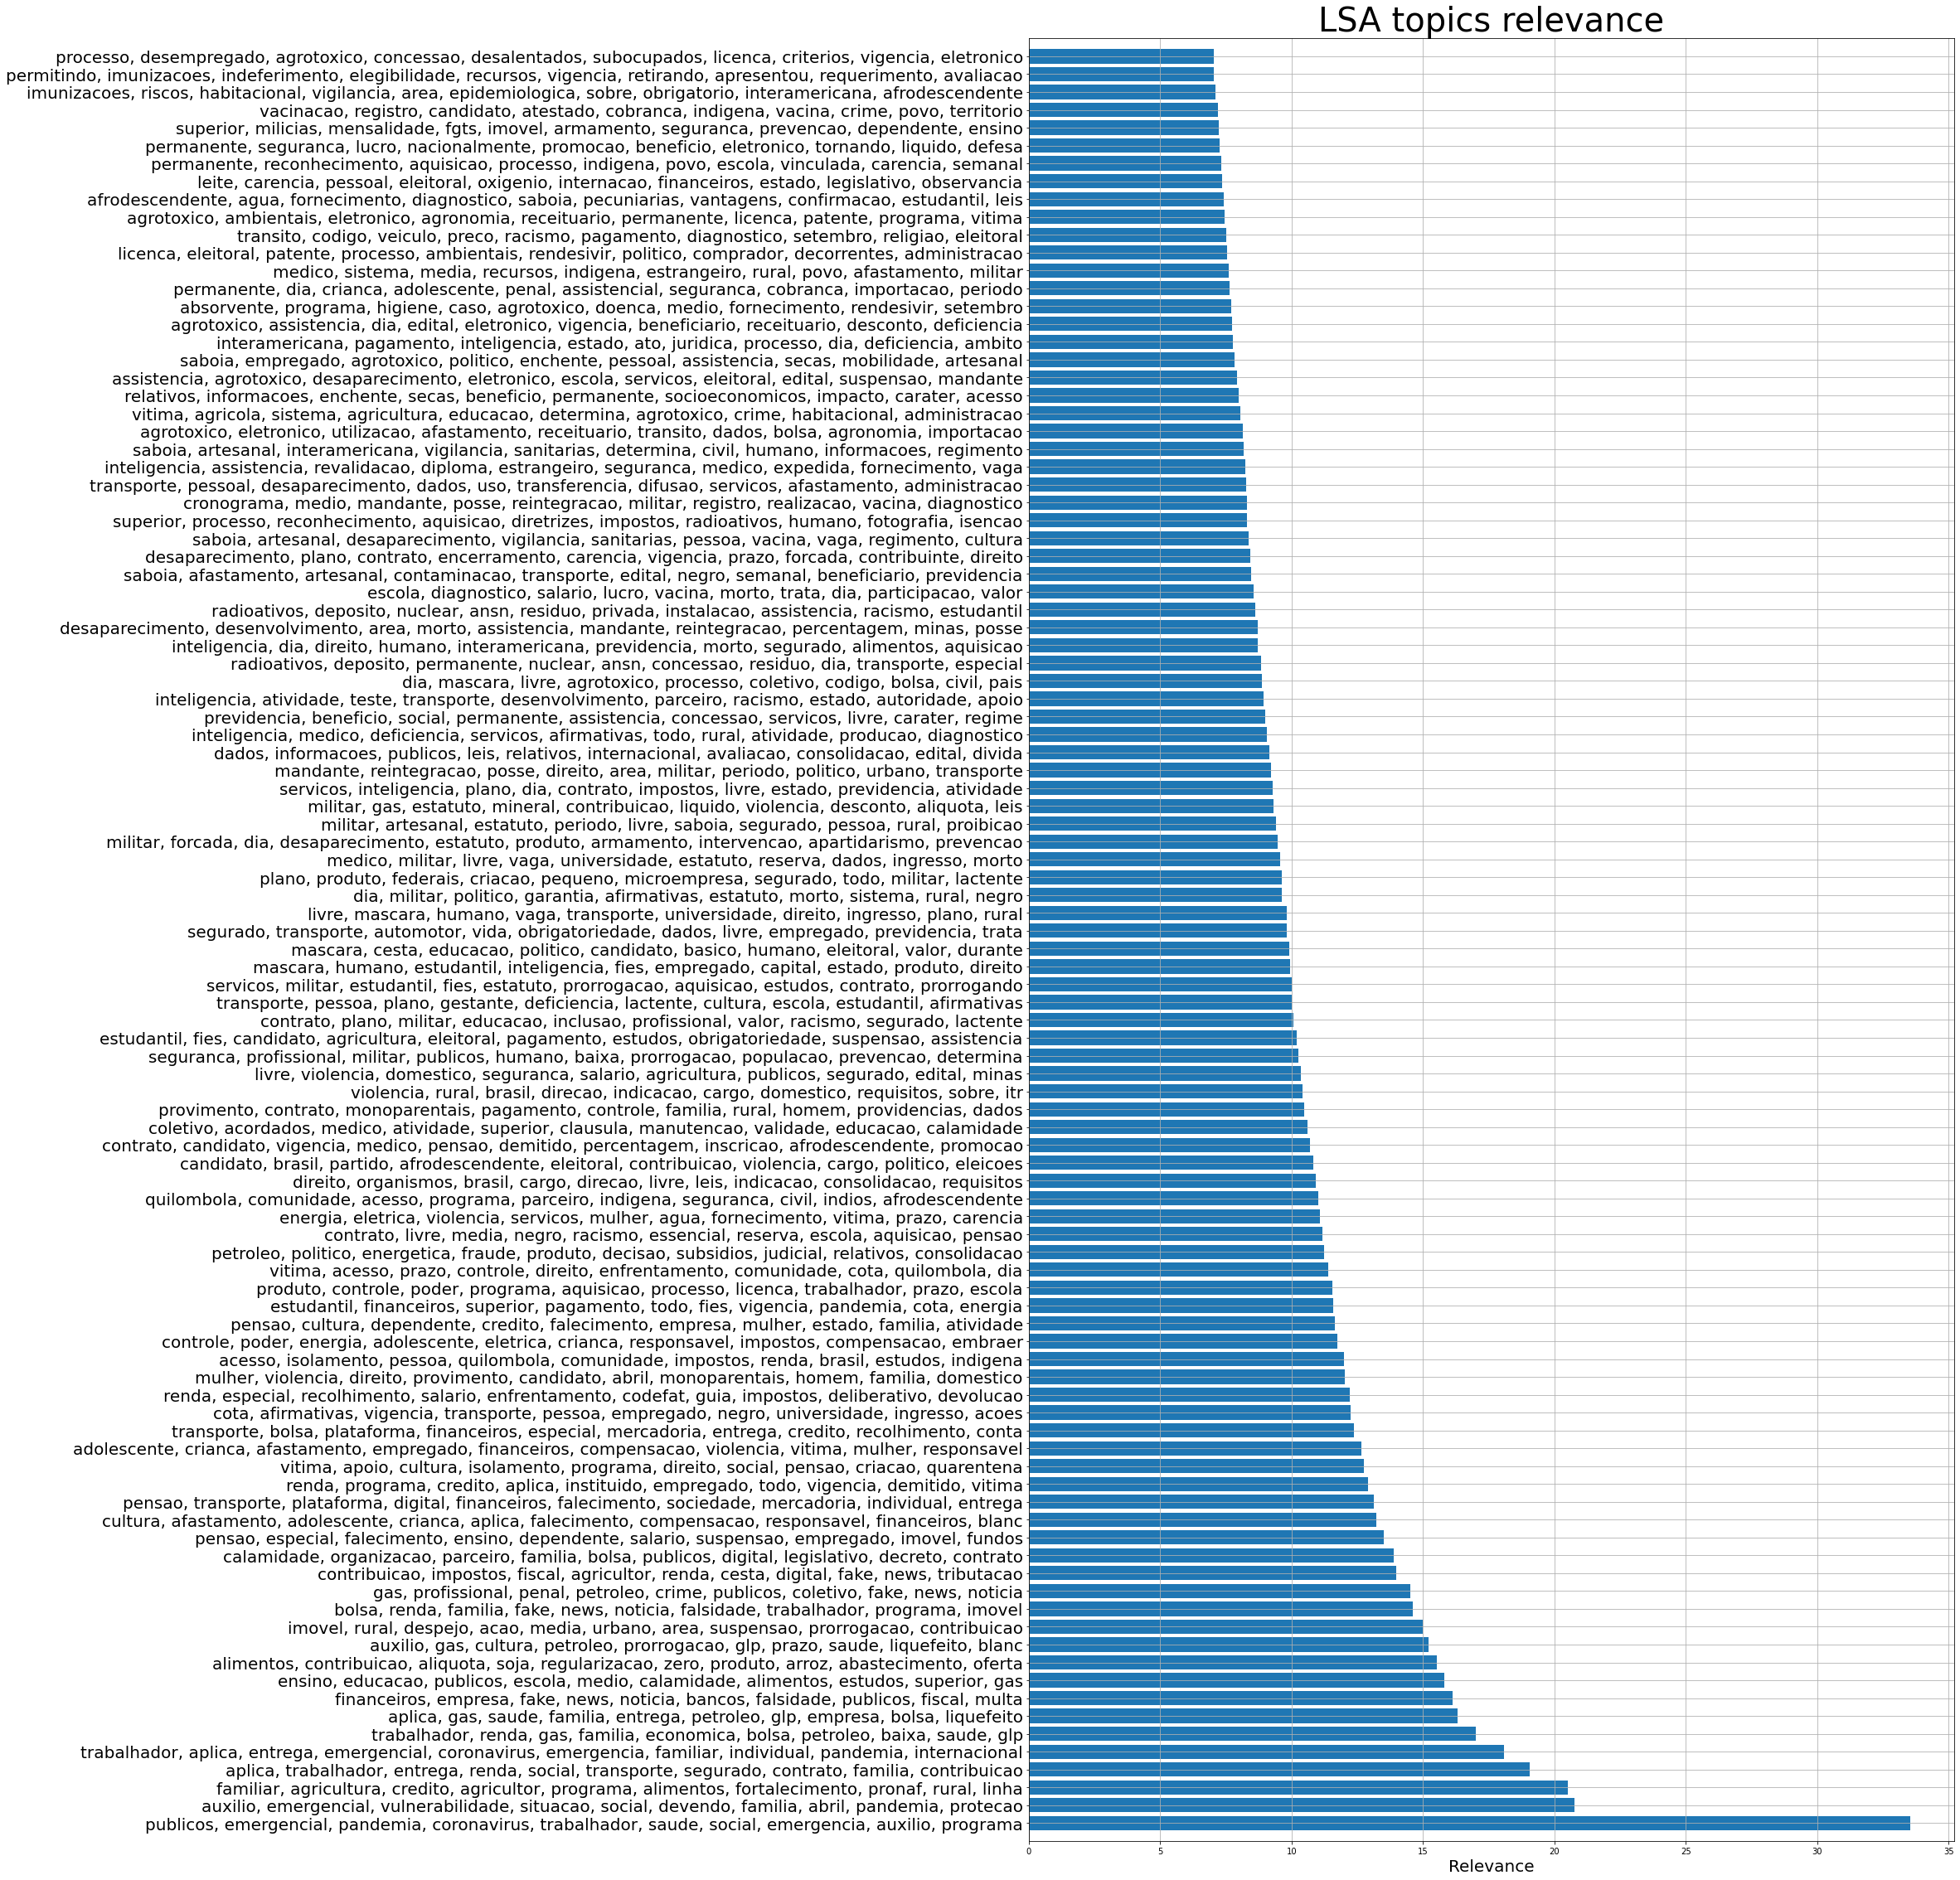

In [202]:
y_pos = np.arange(len(topics))

fig, ax = plt.subplots()
fig.set_figheight(40)
fig.set_figwidth(20)

ax.grid()
ax.barh(y_pos, Sigma, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(topics, fontsize=20)
ax.set_ylim([-1, 100])
ax.set_xlabel('Relevance', fontsize=20)
ax.set_title('LSA topics relevance', fontsize=40)

plt.show()

In [203]:
class Topic(str):
  def set_topic(self, topic):
    self.topic = topic
    return self
  
  def __hash__(self):
    topic_hash = (str(self), self.topic)
    return topic_hash.__hash__()

topics_obj = {Topic(stem_to_word[k]).set_topic(i):v for i, items in enumerate(topics_relevance) for k, v in items}

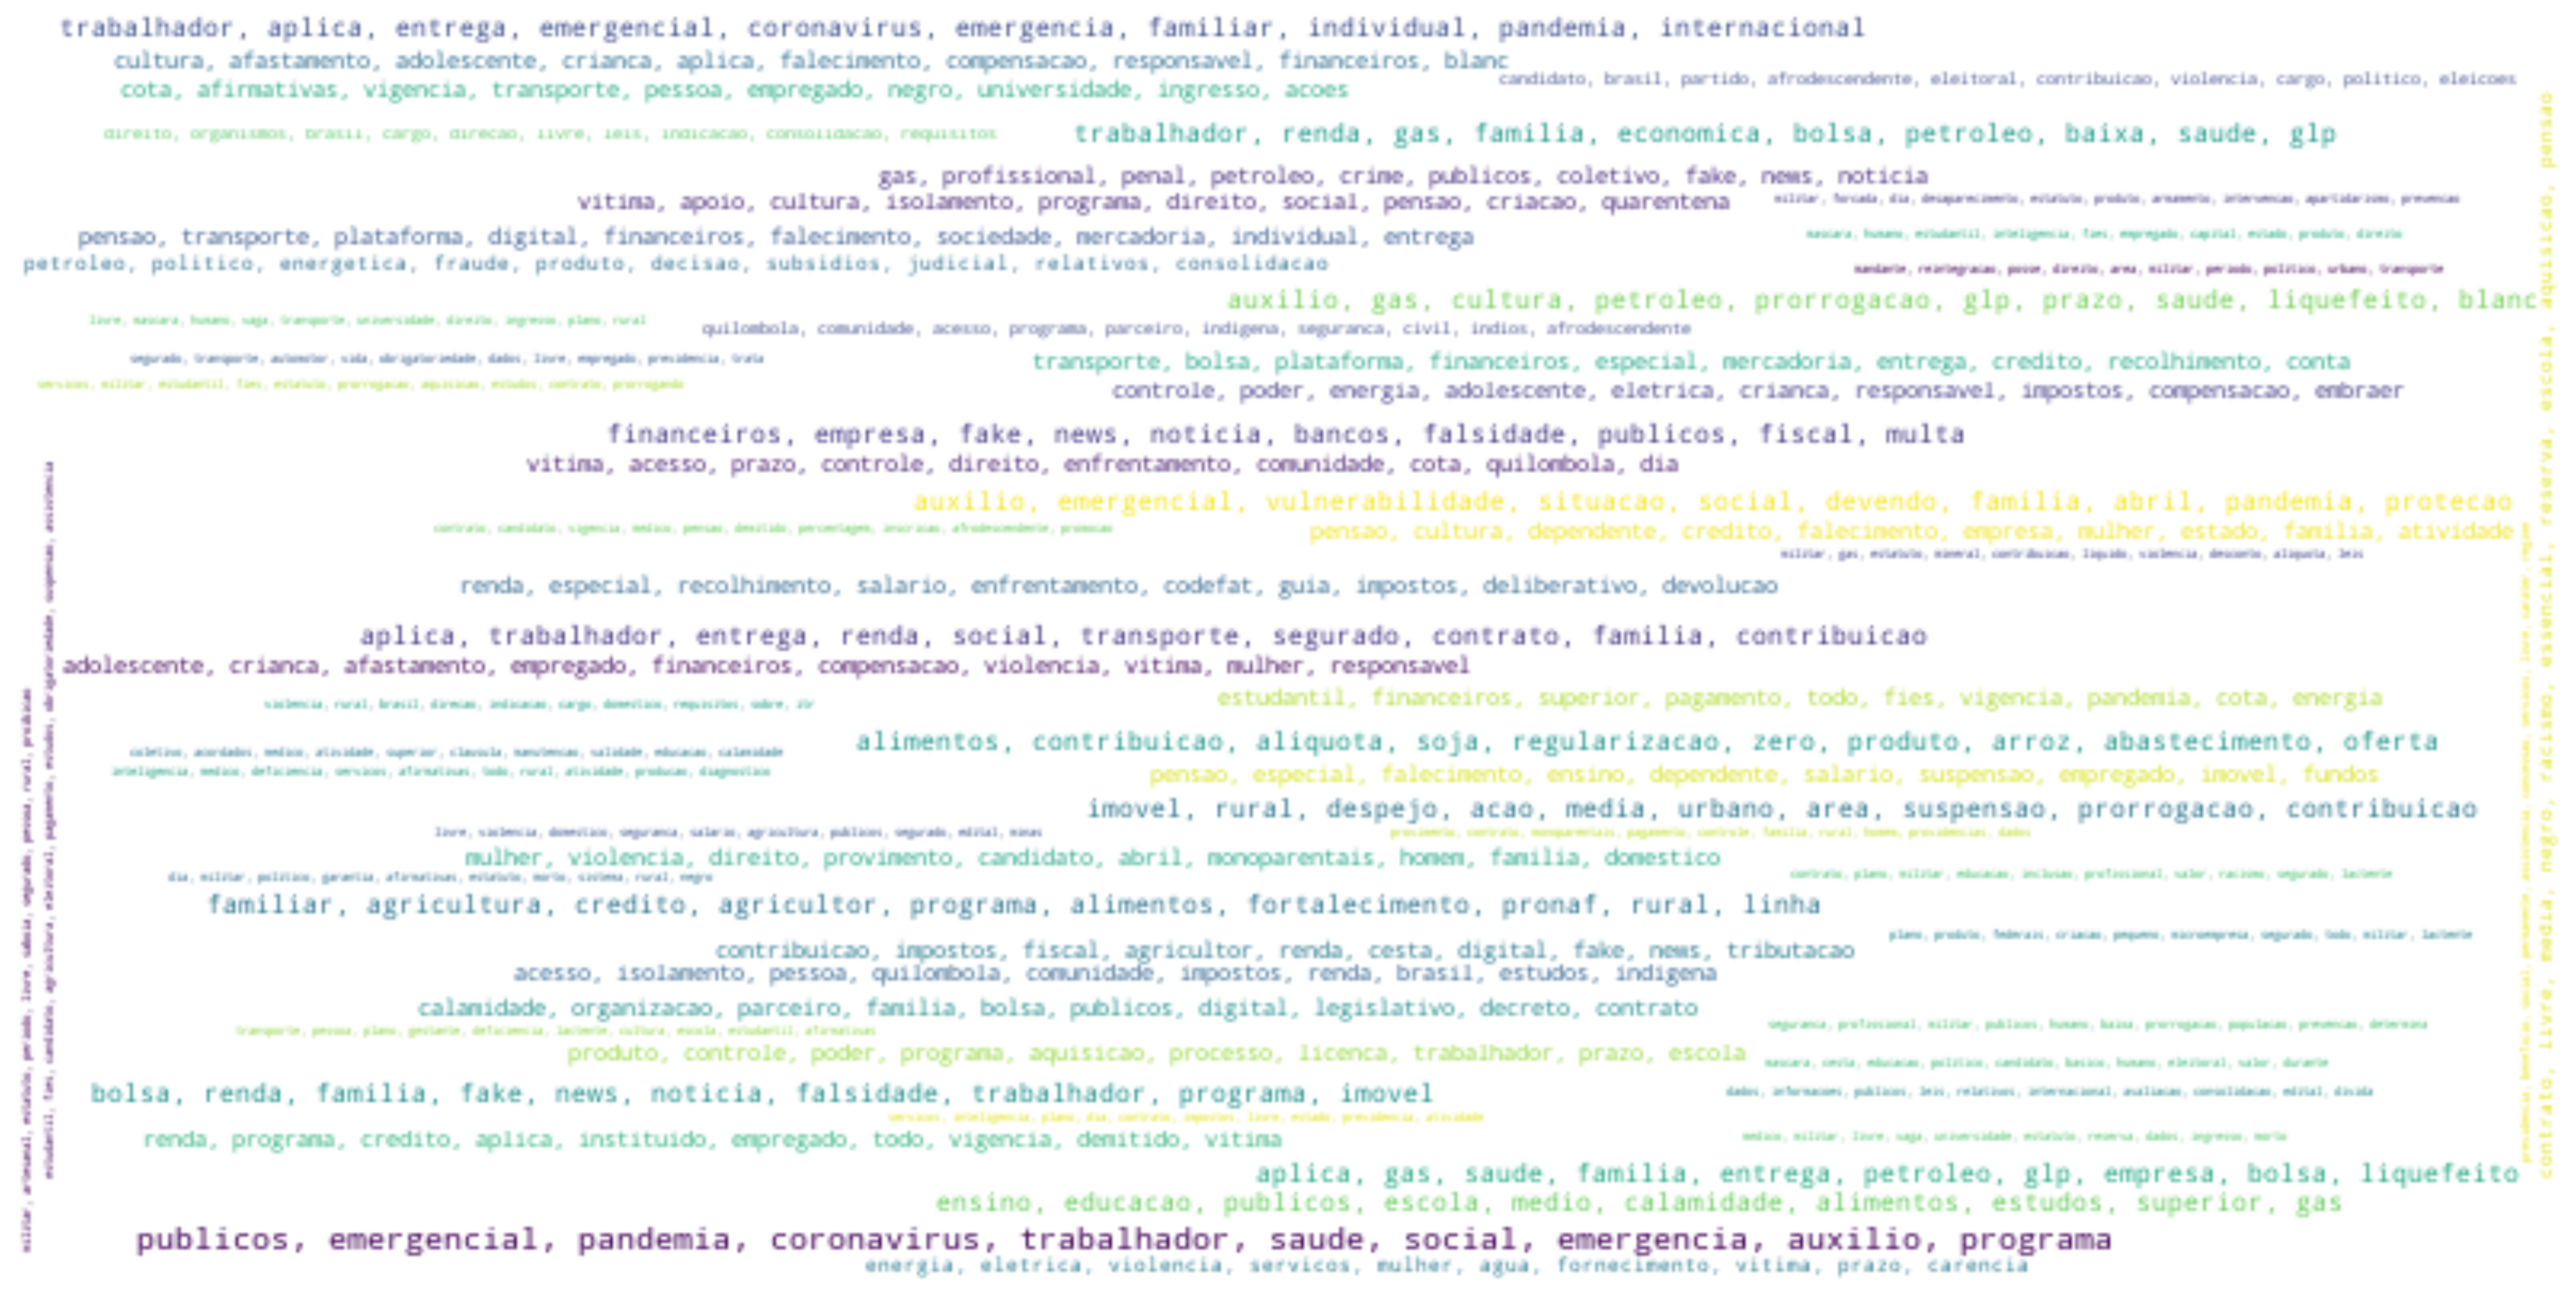

In [204]:
# topic relevance
wordcloud = WordCloud(width=800, height=400, max_words=num_words_per_topic*num_topics, background_color='white').generate_from_frequencies({v:Sigma[i] for i, v in enumerate(topics)})

plt.figure(figsize=(40, 40), dpi=120)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

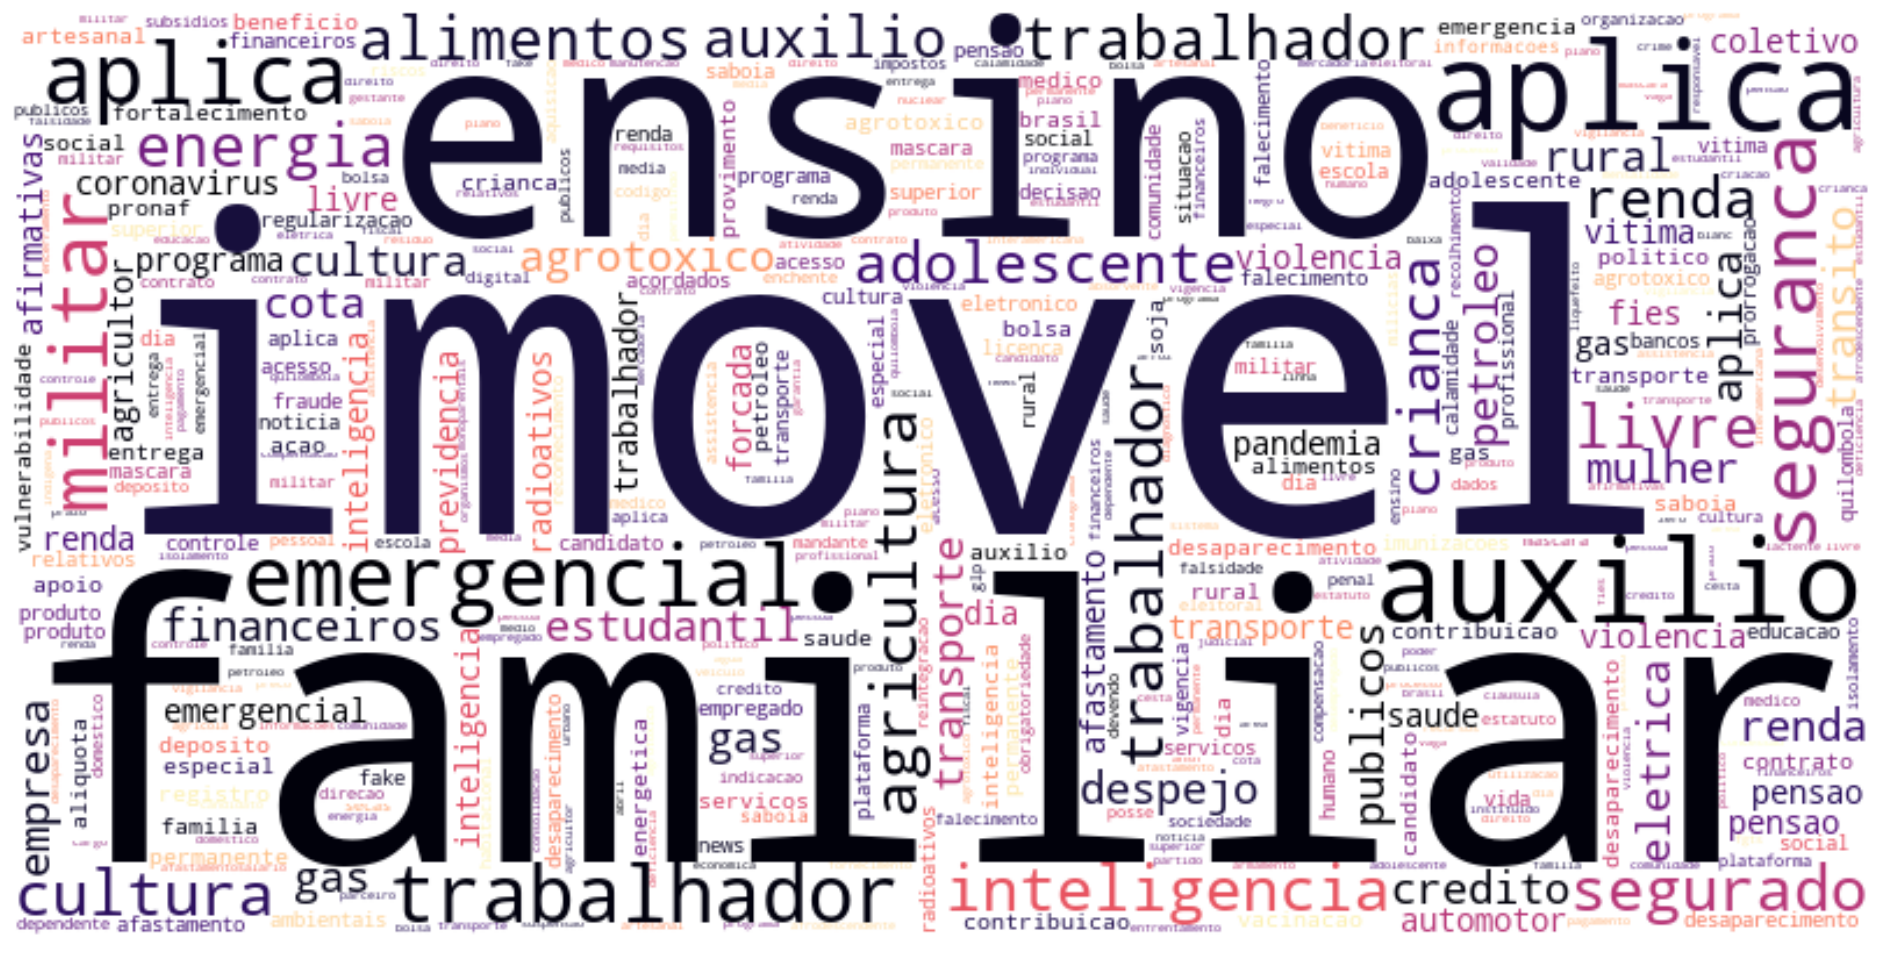

In [205]:
colormap = matplotlib.cm.get_cmap(name='magma', lut=num_topics)

def topic_color(word, **kwargs):
  r, g, b, a = [int(i*255) for i in colormap(word.topic)]
  return f'rgba({r}, {g}, {b}, {a})'

# word relevance for each topic
wordcloud = WordCloud(width=800, height=400, max_words=num_words_per_topic*num_topics, color_func=topic_color, background_color='white').generate_from_frequencies(topics_obj)

plt.figure(figsize=(20, 30), dpi=120)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

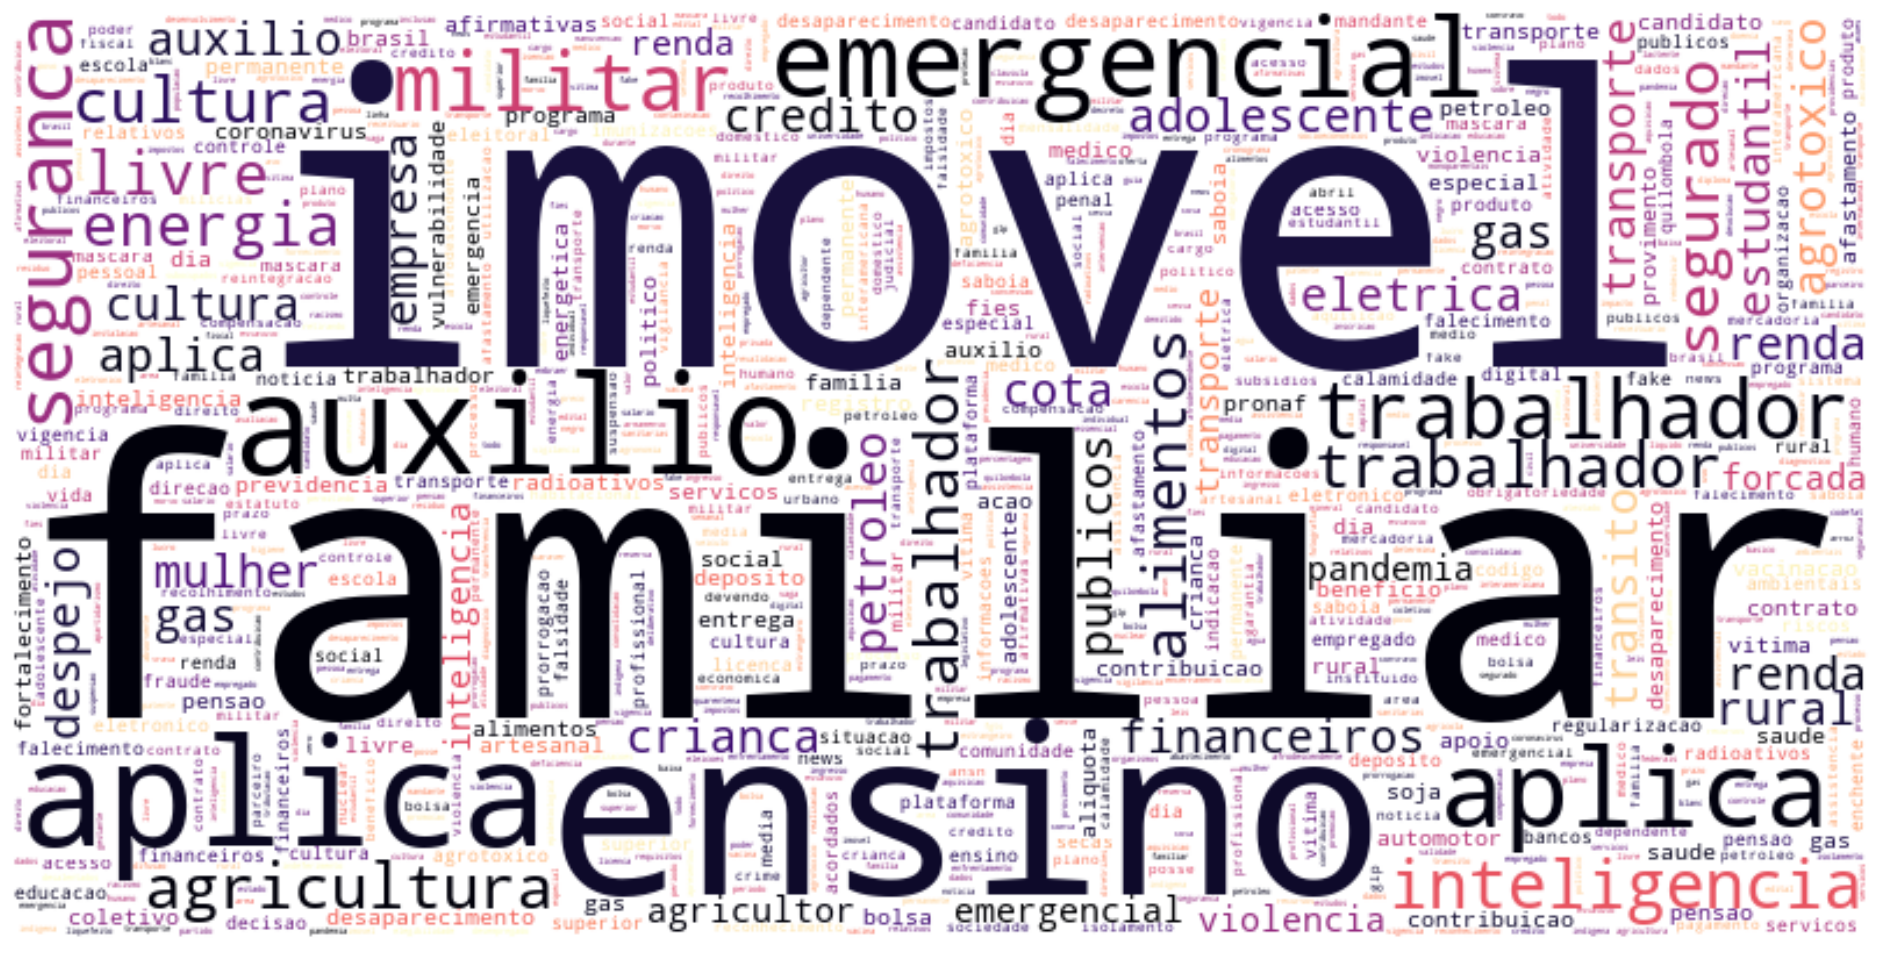

In [206]:
# word relevance for each topic combined with topic relevance
wordcloud = WordCloud(width=800, height=400, max_words=num_words_per_topic*num_topics, color_func=topic_color, background_color='white').generate_from_frequencies({k:v*Sigma[i] for k, v in topics_obj.items()})

plt.figure(figsize=(20, 30), dpi=120)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()